<a href="https://colab.research.google.com/github/zd2011/causal201/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS UA 9201 - Recitation 3
author: Judith Abécassis (judith.abecassis@nyu.edu) & Elise Dumas (elise.dumas@nyu.edu)
With many thanks to [Marco Morucci](https://marcomorucci.com/bio/) and [Causal Inference for Statistics, Social, and Biomedical Sciences by Imbens and Rubin](https://www.cambridge.org/core/books/causal-inference-for-statistics-social-and-biomedical-sciences/71126BE90C58F1A431FE9B2DD07938AB) for inspiration.

In [ ]:
#Load useful libraries
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import CompareMeans, ztest 
import seaborn as sns
sns.set_context('poster')

## Problem 1: Simulating ignorability
We can use a simulation to get a sense of what ignorability implies about our treatment assignment process and to visualize "selection-into-treatment bias". Consider a sample of 1,000 units where the treatment effect is constant (2) and otherwise individual potential outcomes have normal distributions ($Y_i(1)$ is centered on $2$, $Y_i(0)$ is centered on $0$, both with a standard deviation of $3$)

In [ ]:
# Initialize a generator with a fixed seed (function np.random.default_rng)
rg = np.random.default_rng(1007)

# Imagine we had a constant individual-level treatment effect
true_effect = 2

# Our hypothetical population contains 1,000 units - imagine we could observe both Y(1) and Y(0)
N = 1000 # Population size
# generate Y_0 ~ N(0, sigma^2=9) with function rg.normal
Y_0 = rg.normal(scale=3, size=[N, 1])

# create a dataframe with the Y_0 columns
dataset = pd.DataFrame(data=Y_0, columns=['Y_0'])
# add a column for Y_1
dataset = dataset.assign(Y_1 = dataset.Y_0 + true_effect) # Treatment effect is additive

# Let's examine the "table of science"
dataset.head()

,Y_0,Y_1
0,-3.224510,-1.224510
1,-3.817916,-1.817916
2,0.383751,2.383751
3,2.430449,4.430449
4,1.596727,3.596727


Of course in reality, we don't get to observe both $Y_i(0)$ and $Y_i(1)$. We instead have a treatment $T_i$ assigned to each unit which lets us observe an outcome $Y_i$. Let's imagine what that would look like 


In [ ]:
# Random assignment of treatment

# Randomized treatment (.5 probability of treatment) with function rg.binomial
dataset = dataset.assign(T = rg.binomial(1, 0.5, size=(N, 1))) # Not *exactly* half, but independent

# Treatment is a "light switch" - affects what we observe.
# add column Y_obs to the dataset
dataset = dataset.assign(Y_obs = dataset.Y_1 * dataset['T'] + dataset.Y_0 * (1 - dataset['T']))

# Let's see the data now
dataset.head()


,Y_0,Y_1,T,Y_obs
0,-3.224510,-1.224510,1,-1.224510
1,-3.817916,-1.817916,1,-1.817916
2,0.383751,2.383751,0,0.383751
3,2.430449,4.430449,0,2.430449
4,1.596727,3.596727,0,1.596727


Let's compare the distribution of $Y(1)$ and of $Y|T=1$

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


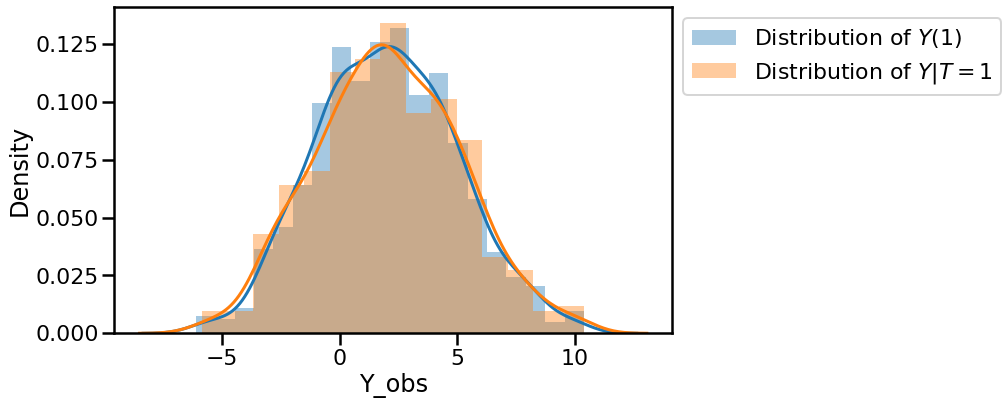

In [ ]:
# Under random assignment, the true distribution of Y1 and the distribution of Y|D=1
# should be similar

# You can use the function hist from matplotlib (tune the transparency parameter alpha for a nicer plot), or try with seaborn
# Potential outcomes

fig, ax = plt.subplots(figsize=(10,6))
h1 = sns.distplot(dataset.Y_1, kde=True, bins='auto',
         label=r"Distribution of $Y(1)$", ax=ax) 

# Observed data
h2 = sns.distplot(dataset[dataset['T']==1].Y_obs, kde=True, bins='auto',
         label=r"Distribution of $Y|T=1$", ax=ax)
ll = ax.legend(bbox_to_anchor=(1,1))


And under repeated randomizations, the expected difference-in-means should equal the true effect. Our single observed estimate is a draw from this distribution.

Create a loop with a large number of repetitions ($N_{\mbox{iter}}\geq 2000$) by generating new treatment assignments and their associated $Y_{\mbox{obs}}$ to visualize the distribution of the ATE estimates.


In [ ]:
simDataset = dataset.copy() # make a placeholder of dataset to use in the simulation
nIter = 2000 # number of iterations to run
est_effect = np.nan * np.ones(nIter) # placeholder

for i in range(nIter):
  # randomly assign treatment again
  simDataset = simDataset.assign(T = rg.binomial(1, 0.5, size=(N, 1)))
  # observed outcome
  simDataset = simDataset.assign(Y_obs = simDataset.Y_1 * simDataset['T'] + simDataset.Y_0 * (1 - simDataset['T']))
  
  # difference-in-means
  est_effect[i] = simDataset[simDataset['T'] == 1].Y_obs.mean() -\
                      simDataset[simDataset['T'] == 0].Y_obs.mean()
  

# What's the average of treatment effect estimates in repeated samples
print(np.mean(est_effect))



1.9881277337071546


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


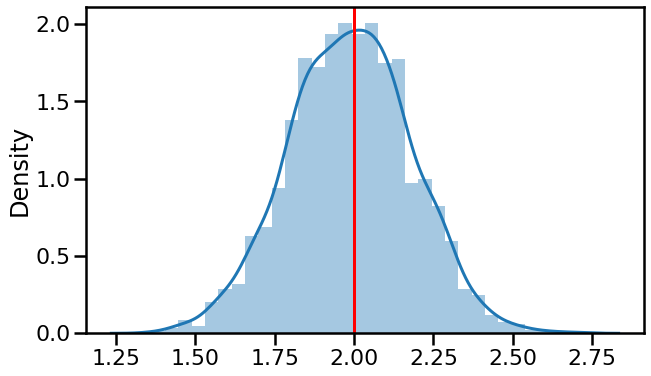

In [ ]:
# What does that distribution look like?
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(est_effect, kde=True, bins='auto', ax=ax)
plt.axvline(x=true_effect, color='red')

What happens if treatment is not randomly assigned -- suppose that units with high $Y(1)$ are more likely to get treated.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


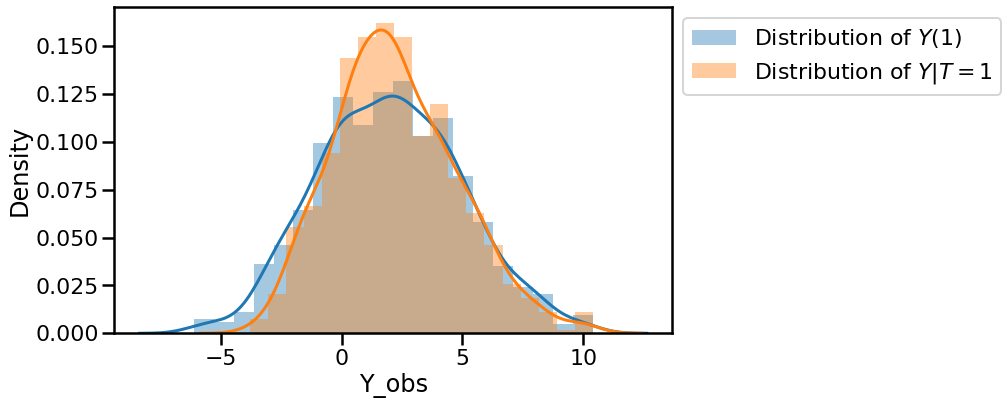

In [ ]:
newDataset = dataset.copy() # placeholder to not override dataset

# Probability of treatment depends on $Y(1)$
newDataset = newDataset.assign(T = [rg.binomial(1, p, 1) for p in sps.norm.cdf(newDataset.Y_1.values)])
# norm.cdf is the normal CDF - high positive values = high probabilities

# Under non-random assignment, the true distribution of Y1 and the distribution of Y|T=1
# should be different
# let's make a plot
fig, ax = plt.subplots(figsize=(10,6))
h1 = sns.distplot(newDataset.Y_1, kde=True, bins='auto',
         label=r"Distribution of $Y(1)$", ax=ax) 

# Observed data
h2 = sns.distplot(newDataset[newDataset['T']==1].Y_obs, kde=True, bins='auto',
         label=r"Distribution of $Y|T=1$", ax=ax)
ll = ax.legend(bbox_to_anchor=(1,1))

Let's now redo the same experience to visualize the distribution of our ATE estimates.

In [ ]:
newSimDataset = newDataset.copy() # make a placeholder of dataset to use in the simulation
nIter = 10000 # number of iterations to run
est_effect_bias = np.nan * np.ones(nIter) # placeholder

for i in range(nIter):
  # randomly assign treatment again
  newSimDataset = newSimDataset.assign(T = [rg.binomial(1, p, 1) for p in sps.norm.cdf(newSimDataset.Y_1.values)])
  # observed outcome
  newSimDataset = newSimDataset.assign(Y_obs = newSimDataset.Y_1 * newSimDataset['T'] + newSimDataset.Y_0 * (1 - newSimDataset['T']))
  
  # difference-in-means
  est_effect_bias[i] = newSimDataset[newSimDataset['T'] == 1].Y_obs.mean() -\
                      newSimDataset[newSimDataset['T'] == 0].Y_obs.mean()
  

# What's the average of treatment effect estimates in repeated samples
print(np.mean(est_effect_bias))



6.696774759871498


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


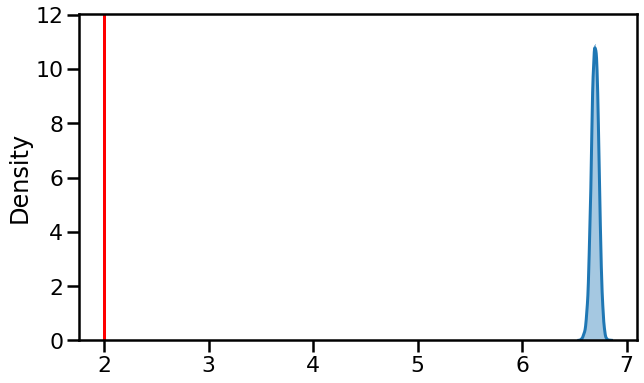

In [ ]:
# What does that distribution look like?
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(est_effect_bias, kde=True, bins='auto', ax=ax)
plt.axvline(x=true_effect, color='red')

What do you conclude?

## Problem 2: Fisher exact p-values

We are now going to compute the Fisher exact p-values for the ATE on simulated data.
1) simulate data where the population distribution for $Y_i(0)$ is normal with mean zero and unit variance, $\mathcal{N}(0, 1)$. The treatment effect is $\tau$ for all units, so that $Y_i(1)=Y_i(0)+\tau \sim\mathcal{N}(\tau,1)$. In each replication, we draw a random sample of size $N = 2000$ with $N_c = 1000$ assigned to the control group and $N_t = 1000$ assigned to the treatment group. We calculate p-values for the sharp null hypothesis that $Y_i(1) = Y_i(0)$ for all units. 

Create a dataframe with the columns corresponding to the potential outcome, the treatment, and the observed outcome.

In [ ]:
N_t = N_c = 100
N = N_t + N_c

tau = 0.5

Y_0= rg.normal(scale=3, size=[N, 1])
dataset = pd.DataFrame(data=Y_0, columns=['Y_0'])
dataset = dataset.assign(Y_1 = dataset.Y_0 + tau)

pre_T = np.zeros(N)
treated = rg.choice(N, N_t, replace=False)
pre_T[treated] = 1
dataset = dataset.assign(T=pre_T)
dataset = dataset.assign(Y_obs = dataset.Y_1 * dataset['T'] + dataset.Y_0 * (1 - dataset['T']))

dataset.head()

,Y_0,Y_1,T,Y_obs
0,0.069627,0.569627,0.0,0.069627
1,-3.733656,-3.233656,1.0,-3.233656
2,0.397768,0.897768,0.0,0.397768
3,-2.300114,-1.800114,0.0,-2.300114
4,-0.759814,-0.259814,1.0,-0.259814


2) Compute the observed test statistic, the absolute value of the difference in average outcomes by treatment status:

$T^{\mbox{dif}} = \left| \bar{Y}_t^{\mbox{obs}} - \bar{Y}_c^{\mbox{obs}}\right| = \left| \frac{\sum_{i:T_i=1} Y_i^{\mbox{obs}}}{N_t} - \frac{\sum_{i:T_i=0} Y_i^{\mbox{obs}}}{N_c}\right|$.

In [ ]:
T_dif = np.abs(dataset[dataset['T']==1].Y_obs.mean() - dataset[dataset['T']==0].Y_obs.mean())
print(T_dif)

0.6235190337734072


3) Execute a high number of permutations of the treatment assignment to compute the distribution of the $T^{\mbox{dif}}$ statistic under the sharp null assumption of no difference between the two potential outcomes.

In [ ]:
Niter= 2000
null_diff = np.zeros(Niter)
for i in range(Niter):
  # permute the treatment variable with the function permutation from numpy.random
  dataset = dataset.assign(T_permute=rg.permutation(dataset['T']))
  null_diff[i] = np.abs(dataset[dataset['T_permute']==1].Y_obs.mean() - dataset[dataset['T_permute']==0].Y_obs.mean())

4) Represent the obtained ATE null distribution, as well as the true and observed ATEs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


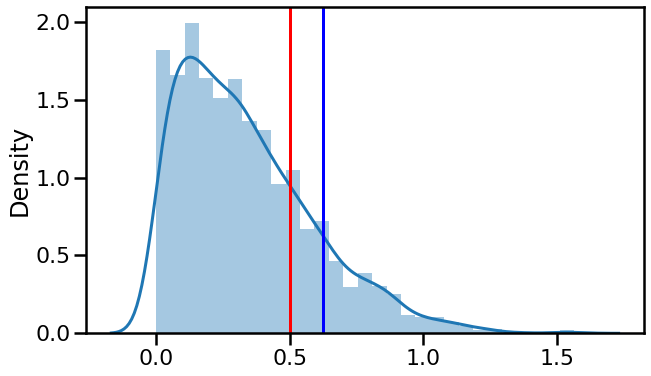

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(null_diff, kde=True, bins='auto', ax=ax)
plt.axvline(x=tau, color='red')
plt.axvline(x=T_dif, color='blue')

5) Compute the associated p-value, following the formula

$$\mbox{p-val}_{2tailed} = \frac{1}{N_{\mbox{iter}}}\sum_{sim=1}^{N_{\mbox{iter}}} \mathbb{1}(|t_{sim}| > |t_{obs}|).$$

In [ ]:
np.mean(np.abs(null_diff)>abs(T_dif))

0.138

6) Compare with the asymptotical p-value obtained with a Z-test.

In [ ]:
ztest(dataset[dataset['T']==1].Y_obs, dataset[dataset['T']==0].Y_obs)

(1.460531062946379, 0.1441441768422838)